<a href="https://colab.research.google.com/github/Pranjal-OG/Analyze-This/blob/main/Bias_Detection_%26_Mitigation_in_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 3.7 MB/s eta 0:00:00


pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


📤 Upload your CSV dataset:


Saving archive.zip to archive.zip
✅ Dataset 'archive.zip' loaded successfully!

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9709 entries, 0 to 9708
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               9709 non-null   int64  
 1   Gender           9709 non-null   int64  
 2   Own_car          9709 non-null   int64  
 3   Own_property     9709 non-null   int64  
 4   Work_phone       9709 non-null   int64  
 5   Phone            9709 non-null   int64  
 6   Email            9709 non-null   int64  
 7   Unemployed       9709 non-null   int64  
 8   Num_children     9709 non-null   int64  
 9   Num_family       9709 non-null   int64  
 10  Account_length   9709 non-null   int64  
 11  Total_income     9709 non-null   float64
 12  Age              9709 non-null   float64
 13  Years_employed   9709 non-null   float64
 14  Income_type      9709 non-null   object 
 15  Education_ty

/tmp/ipython-input-50213414.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Target', palette='viridis')


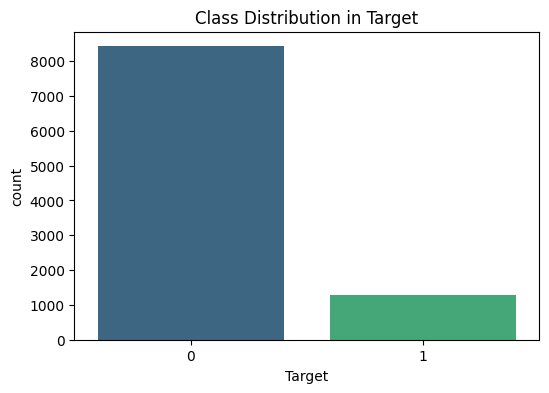

/tmp/ipython-input-50213414.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Gender', palette='viridis')


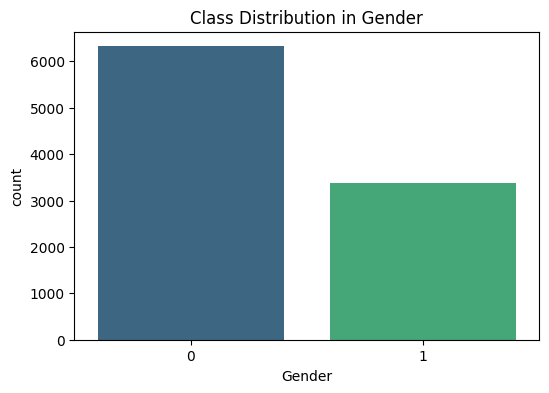


✅ Preprocessing complete!

✅ AIF360 dataset created successfully!

Model Performance:
Accuracy: 0.8586
Classification Report:
               precision    recall  f1-score   support

           0       0.86      1.00      0.92      2499
           1       1.00      0.00      0.01       414

    accuracy                           0.86      2913
   macro avg       0.93      0.50      0.47      2913
weighted avg       0.88      0.86      0.79      2913



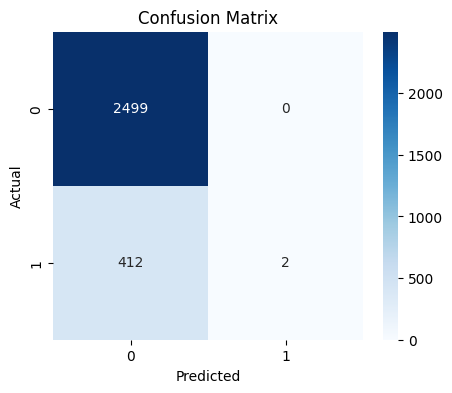

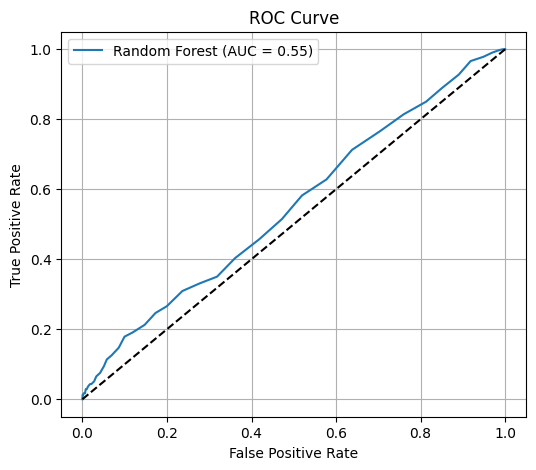


Bias Metrics:
Disparate Impact: 0.9232
Statistical Parity Difference: -0.0107


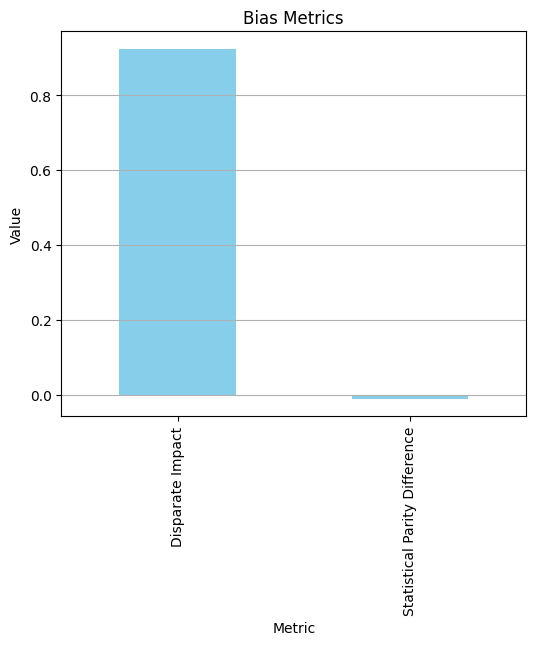


✅ Bias mitigation completed with Reweighing!


In [1]:
# ======================================
# 🔧 Import Libraries
# ======================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

# For Colab file uploads
from google.colab import files

# ======================================
# ⚡ Install AIF360 if missing
# ======================================
try:
    from aif360.datasets import StandardDataset
    from aif360.metrics import BinaryLabelDatasetMetric
    from aif360.algorithms.preprocessing import Reweighing
except ImportError:
    !pip install aif360 tensorflow scikit-learn
    from aif360.datasets import StandardDataset
    from aif360.metrics import BinaryLabelDatasetMetric
    from aif360.algorithms.preprocessing import Reweighing

# ======================================
# 📂 Step 1: Upload Dataset
# ======================================
print("📤 Upload your CSV dataset:")
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)
print(f"✅ Dataset '{file_name}' loaded successfully!")

# ======================================
# 🧾 Step 2: Inspect Dataset
# ======================================
print("\nDataset Info:")
print(df.info())

print("\nTarget column unique values:", df['Target'].unique())
print("Gender column unique values:", df['Gender'].unique())

# Visualize distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Target', palette='viridis')
plt.title('Class Distribution in Target')
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Gender', palette='viridis')
plt.title('Class Distribution in Gender')
plt.show()

# ======================================
# 🧹 Step 3: Preprocess Dataset
# ======================================
def preprocess_data(data, target_column, protected_column):
    # Drop missing values
    data = data.dropna()

    # Ensure binary Target and Protected Attribute
    data[target_column] = data[target_column].astype(int)
    data[protected_column] = data[protected_column].astype(int)

    # Encode categorical variables
    for col in data.select_dtypes(include=['object']).columns:
        if col not in [target_column, protected_column]:
            data[col], _ = pd.factorize(data[col])

    # Scale numeric columns
    numeric_cols = [c for c in data.select_dtypes(include=['float64','int64']).columns if c not in [target_column, protected_column]]
    scaler = StandardScaler()
    data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

    features = [c for c in data.columns if c != target_column]
    return data, features

target_column = 'Target'
protected_column = 'Gender'

df, features = preprocess_data(df, target_column, protected_column)
print("\n✅ Preprocessing complete!")

# ======================================
# 🧠 Step 4: Split Dataset
# ======================================
X = df[features]
y = df[target_column]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# ======================================
# ⚙️ Step 5: Convert to AIF360 Dataset
# ======================================
def create_aif_dataset(data, label_name, protected_attribute):
    return StandardDataset(
        data,
        label_name=label_name,
        favorable_classes=[1],
        protected_attribute_names=[protected_attribute],
        privileged_classes=[[1]]
    )

aif_data = create_aif_dataset(df, target_column, protected_column)
print("\n✅ AIF360 dataset created successfully!")

# ======================================
# 🏋️ Step 6: Train Model
# ======================================
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("\nModel Performance:")
print("Accuracy:", round(accuracy_score(y_test, y_pred),4))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0','1'], yticklabels=['0','1'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
y_pred_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_pred_prob):.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

# ======================================
# ⚖️ Step 7: Bias Detection
# ======================================
metric = BinaryLabelDatasetMetric(
    aif_data,
    privileged_groups=[{protected_column: 1}],
    unprivileged_groups=[{protected_column: 0}]
)

print("\nBias Metrics:")
print("Disparate Impact:", round(metric.disparate_impact(),4))
print("Statistical Parity Difference:", round(metric.statistical_parity_difference(),4))

# Visualize Bias
bias_df = pd.DataFrame({
    'Metric':['Disparate Impact','Statistical Parity Difference'],
    'Value':[metric.disparate_impact(), metric.statistical_parity_difference()]
})
bias_df.plot(x='Metric', y='Value', kind='bar', legend=False, figsize=(6,5), color='skyblue')
plt.title("Bias Metrics")
plt.ylabel("Value")
plt.grid(axis='y')
plt.show()

# ======================================
# 🛠 Step 8: Bias Mitigation (Reweighing)
# ======================================
rw = Reweighing(
    unprivileged_groups=[{protected_column:0}],
    privileged_groups=[{protected_column:1}]
)
rw.fit(aif_data)
aif_data_transformed = rw.transform(aif_data)
print("\n✅ Bias mitigation completed with Reweighing!")
